In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import skimage
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
df = pd.read_pickle(r"../../../Datasets/Dataset_A_resized_256.pkl")

In [7]:
print("MR Image shape:   {}".format(df["Tumor Mask"][0].shape))
print("Tumor Mask shape: {}".format(df["Tumor Mask"][0].shape))

MR Image shape:   (256, 256)
Tumor Mask shape: (256, 256)


In [8]:
classes_dict = {"Not Tumor": 0, "Meningioma": 1, "Glioma": 2, "Pituitary": 3}
for index, row in df.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]

In [9]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, 0]

df.Images = df.Images.apply(normalize)

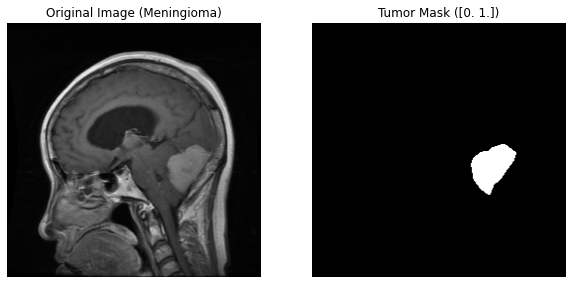

In [10]:
randInt = np.random.randint(0,len(df))

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2

img  = df.Images[randInt]
mask = df["Tumor Mask"][randInt]
tumorBorder = df["Tumor Border"][randInt]


# Display Original Image
fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image ({})'.format(df.Labels[randInt]))
plt.axis('off')
  
# Display Tumor Mask
fig.add_subplot(rows, columns, 2)
plt.imshow(mask, cmap='gray')
plt.title('Tumor Mask ({})'.format(np.unique(mask)))
plt.axis('off')
plt.show()

In [11]:
df.head()

,PID,Images,Tumor Mask,Tumor Border,Labels,File name
0,100360,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[267.6152450090744, 231.37568058076226, 277.83...",Meningioma,1.mat
1,101016,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[248.86411149825784, 256.89198606271776, 238.1...",Meningioma,10.mat
2,107494,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[193.26370732550265, 175.8076305348121, 185.15...",Meningioma,100.mat
3,112649,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[225.95188511210213, 231.1718956592464, 233.40...",Pituitary,1000.mat
4,112649,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[231.61100841767436, 237.4012836281162, 241.02...",Pituitary,1001.mat


In [12]:
## Splitting Images form masks
img_size = 256

Y = df["Tumor Mask"].tolist()
X = df['Images'].tolist()

## Adding extra Color channel to the grayscale images
Y = np.array(Y).reshape(-1, img_size, img_size)
Y = Y.astype(float)

X = np.array(X).reshape(-1, img_size, img_size)

print(f"shape of images: {X.shape}\nshape of labels: {Y.shape}")

shape of images: (3064, 256, 256)
shape of labels: (3064, 256, 256)


In [14]:
from sklearn.preprocessing import LabelEncoder

train_masks = Y
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3], dtype=int64)

In [25]:
train_masks_reshaped_encoded.shape

(200802304,)

In [19]:
from tensorflow.keras.utils import normalize

train_images = np.expand_dims(X, axis=3)
train_images = train_images/255

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [20]:
train_masks_input.shape

(3064, 256, 256, 1)

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
n_classes = len(np.unique(train_masks_input))

X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.25, random_state=42)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1 2 3]


In [13]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train_cat.shape)
print("X_test shape :",X_test.shape,"| y_test shape : ", y_test_cat.shape)

print("\nTotal Data: ", len(df))

X_train shape: (2298, 256, 256, 1) | y_train shape: (2298, 256, 256, 4)
X_test shape : (766, 256, 256, 1) | y_test shape :  (766, 256, 256, 4)

Total Data:  3064


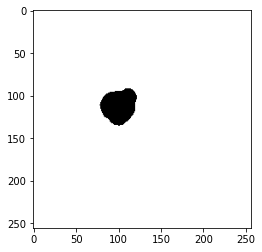

In [14]:
plt.imshow(y_test_cat[0, :, :, 0], 'gray')

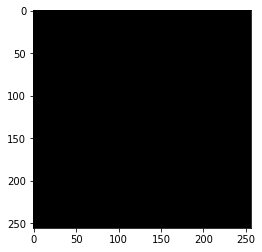

In [15]:
plt.imshow(y_test_cat[0, :, :, 1], 'gray')

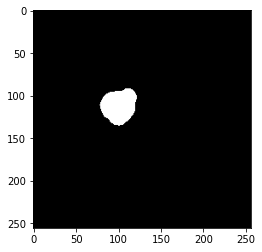

In [16]:
plt.imshow(y_test_cat[0, :, :, 2], 'gray')

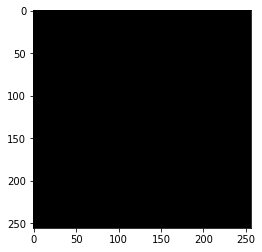

In [17]:
plt.imshow(y_test_cat[0, :, :, 3], 'gray')

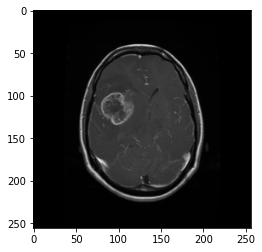

In [18]:
plt.imshow(X_test[0, :, :, :], 'gray')

In [19]:
X_test[0, :, :, :].max()

1.0

In [20]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(train_masks_reshaped_encoded),
                                                 y = train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

Class weights are...: [ 0.25429786 60.93108919 24.36493005 98.53238675]


In [21]:
# class_weights = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2], 3: class_weights[3]}
# print("Class weights are...:", class_weights)

In [22]:
# Building Unet by dividing encoder and decoder into blocks
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(n_classes, input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [23]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [24]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(n_classes, input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [25]:
# model = tf.keras.models.load_model(r".\experiments\exp#12\weights\best.h5")

In [26]:
from keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath= os.path.join(weights, "best.h5"),
    verbose=100, 
    save_best_only=False, 
    mode='max')
    
history = model.fit(X_train, 
        y_train_cat, 
        batch_size = 4, 
        verbose=1, 
        epochs=100, 
        validation_data=(X_test, y_test_cat), 
        callbacks=[model_checkpoint_callback],
#         sample_weight=np.array(class_weights),
        shuffle=False)

Epoch 1/100
575/575 [==============================] - 105s 172ms/step - loss: 0.0927 - accuracy: 0.9805 - val_loss: 0.4953 - val_accuracy: 0.7232

Epoch 00001: saving model to ./experiments/exp#16\weights\best.h5
Epoch 2/100
575/575 [==============================] - 105s 183ms/step - loss: 0.0565 - accuracy: 0.9842 - val_loss: 0.0645 - val_accuracy: 0.9838

Epoch 00002: saving model to ./experiments/exp#16\weights\best.h5
Epoch 3/100
575/575 [==============================] - 101s 176ms/step - loss: 0.0497 - accuracy: 0.9849 - val_loss: 0.0641 - val_accuracy: 0.9839

Epoch 00003: saving model to ./experiments/exp#16\weights\best.h5
Epoch 4/100
575/575 [==============================] - 102s 178ms/step - loss: 0.0454 - accuracy: 0.9856 - val_loss: 0.0520 - val_accuracy: 0.9856

Epoch 00004: saving model to ./experiments/exp#16\weights\best.h5
Epoch 5/100
575/575 [==============================] - 102s 177ms/step - loss: 0.0424 - accuracy: 0.9862 - val_loss: 0.0630 - val_accuracy: 0.98

575/575 [==============================] - 100s 174ms/step - loss: 0.0041 - accuracy: 0.9984 - val_loss: 0.0351 - val_accuracy: 0.9937

Epoch 00077: saving model to ./experiments/exp#16\weights\best.h5
Epoch 78/100
575/575 [==============================] - 99s 173ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.0441 - val_accuracy: 0.9940

Epoch 00078: saving model to ./experiments/exp#16\weights\best.h5
Epoch 79/100
575/575 [==============================] - 99s 173ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0530 - val_accuracy: 0.9939

Epoch 00079: saving model to ./experiments/exp#16\weights\best.h5
Epoch 80/100
575/575 [==============================] - 99s 173ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.0564 - val_accuracy: 0.9939

Epoch 00080: saving model to ./experiments/exp#16\weights\best.h5
Epoch 81/100
575/575 [==============================] - 99s 172ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0469 - val_accuracy: 0.9938

Epoch 00

In [27]:
# acc = model.evaluate(X_test, y_test_cat)
# name = str(round(acc, 4))

In [28]:
# Save The Trained model along with it training history   
metrics = pd.DataFrame(history.history)
metrics.to_pickle(os.path.join(results, "metrics"+'.pkl'))
model.save(os.path.join(weights, "First_Mulit_UNet" + '.h5'))

In [29]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.092708,0.980529,0.495262,0.723178
1,0.056490,0.984189,0.064482,0.983751
2,0.049658,0.984854,0.064082,0.983858
3,0.045353,0.985627,0.052042,0.985596
4,0.042376,0.986245,0.063012,0.983413
...,...,...,...,...
95,0.001358,0.999424,0.056287,0.994040
96,0.001092,0.999543,0.059263,0.994032
97,0.001126,0.999525,0.058921,0.993895
98,0.001433,0.999388,0.052281,0.993774


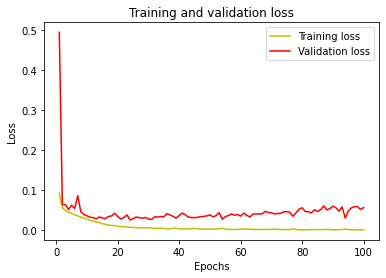

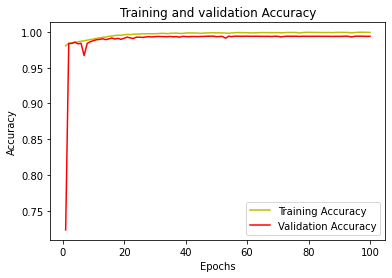

In [30]:
loss = metrics['loss']
val_loss = metrics['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']

plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.show()

In [31]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node U-Net/batch_normalization/FusedBatchNormV3 (defined at \AppData\Local\Temp/ipykernel_18316/1172060044.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_218152]

Function call stack:
predict_function
